## Multilabel with Segmentation U-Net, FCN & Mask RCNN

In [1]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from tqdm import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split
from PIL import Image
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.callbacks import TensorBoard
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

# Prepare Dataset

In [2]:
df = pd.read_csv('data/label.csv')
df

,Filename,Label
0,image_1.jpg,"[Kerbau,Manusia]"
1,image_10.jpg,"[Kerbau,Manusia]"
2,image_100.jpg,[Kerbau]
3,image_101.jpg,"[Kerbau,Manusia]"
4,image_102.jpg,"[Kerbau,Manusia]"
...,...,...
2110,image_1999.jpg,"[Kerbau,Manusia,Truk]"
2111,image_2.jpg,"[Kerbau,Manusia]"
2112,image_20.jpg,"[Kerbau,Manusia]"
2113,image_200.jpg,[Kerbau]


In [3]:
# buat daftar unique dari semua label
unique_label = set()
for label in df["Label"]:
    label_list = label.strip("[]").split(",")
    for label in label_list:
        unique_label.add(label.strip())
        
# buatkan kolom one-hot encodinf setiap label
for label in unique_label:
    df[label] = df["Label"].apply(lambda x: int(label in x))

In [4]:
df.head()

,Filename,Label,Kerbau,Hewan liar,Manusia,Truk,Motor
0,image_1.jpg,"[Kerbau,Manusia]",1,0,1,0,0
1,image_10.jpg,"[Kerbau,Manusia]",1,0,1,0,0
2,image_100.jpg,[Kerbau],1,0,0,0,0
3,image_101.jpg,"[Kerbau,Manusia]",1,0,1,0,0
4,image_102.jpg,"[Kerbau,Manusia]",1,0,1,0,0


<Axes: xlabel='Label'>

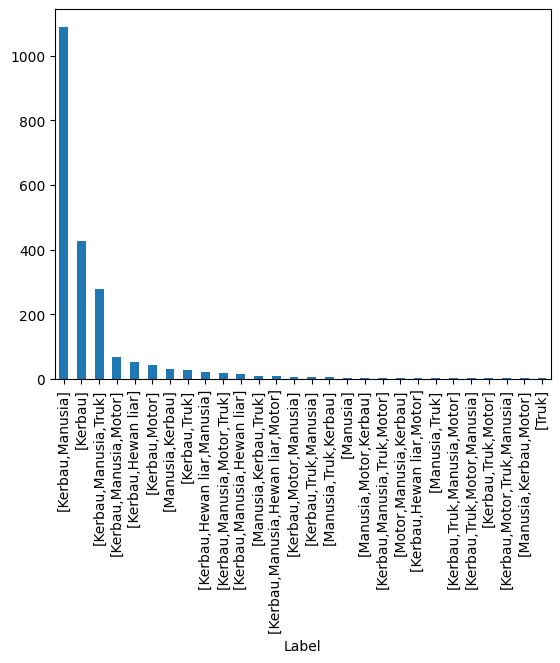

In [5]:
df['Label'].value_counts().plot(kind='bar')

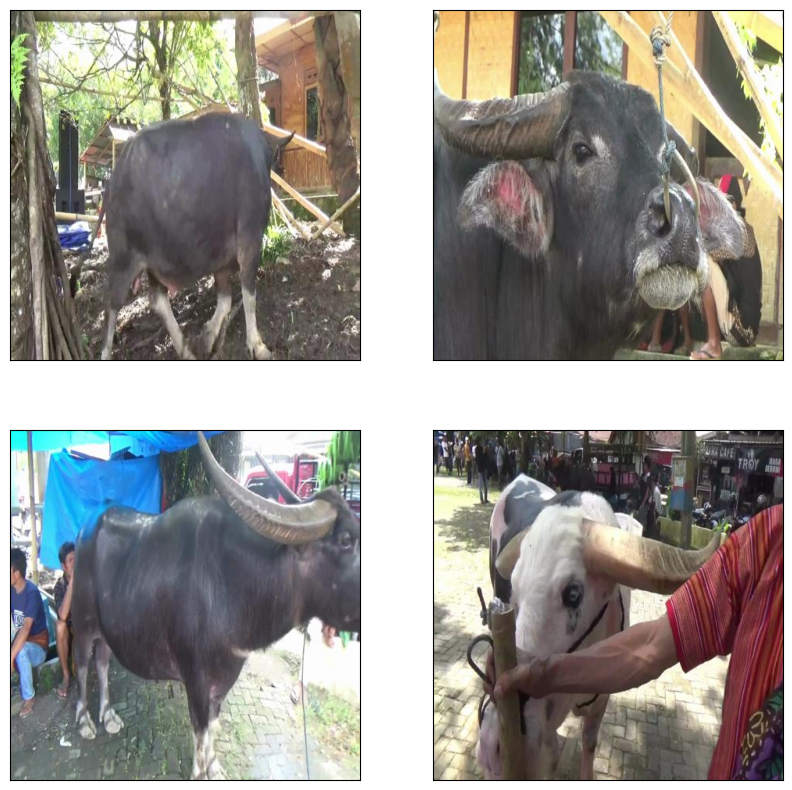

In [6]:
random_index = np.random.randint(0, len(df), 10)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10),
                    subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread("data/image/"+ df.Filename[random_index[i]]))
plt.show()

In [7]:
X_dataset = []
for i in tqdm(range(df.shape[0])):
    img = image.load_img('data/image/' + df["Filename"][i], target_size=(448, 448, 3))
    img = image.img_to_array(img)
    img /= 255.0
    X_dataset.append(img)

100%|██████████| 2115/2115 [00:04<00:00, 492.99it/s]


In [8]:
X = np.array(X_dataset)

In [9]:
y = np.array(df.drop(columns=["Filename","Label"], axis=1))
y

array([[1, 0, 1, 0, 0],
       [1, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [1, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]], dtype=int64)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Metrci Evaluations

In [11]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

METRICS = ["accuracy",
          tf.keras.metrics.TruePositives(name="true_positive"),
          tf.keras.metrics.TrueNegatives(name="true_negative"),
          tf.keras.metrics.FalsePositives(name="false_positive"),
          tf.keras.metrics.FalseNegatives(name="false_negative"),
          recall_m,precision_m,f1_m]

# U-Net

Berikut arsitektur keseluruhan U-Net yang akan digunakan:

<img src='https://drive.google.com/uc?export=view&id=1BeQSKL2Eq6Fw9iRXsN1hgunY-CS2nH7V' alt='unet'>

UNet terdiri dari encoder (downsampler) dan decoder (upsampler) dengan hambatan di antaranya. Panah abu-abu sesuai dengan koneksi lompatan yang menggabungkan output blok encoder ke setiap tahap decoder.

### Encoder
Block-block encoder berisi 2 layer Conv2D diakttifkan oleh relu, serta di ikuti oleh MaxpPooling dan Dropout

In [12]:
def conv2d_block(input_tensor, n_filter, kernel_size=3):
    ''' 
    Arg:
    input_tensor (tensor) - tensor masukan
    n_filter (int) - jumlah filter
    kernel_size (int) -- ukuran kernel untuk konvolusi

    return
    tensor dari fitur keluaran
    '''
    x = input_tensor
    for i in range(2):
        x = tf.keras.layers.Conv2D(filters=n_filter, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",padding='same')(x)
        x = tf.keras.layers.Activation("relu")(x)
    return x

def encoder_block(inputs, n_filter, pool_size=2, dropout=0.3):
    '''
    Arg:
    input (tensor) - tensor masukan
    n_filter (int) - jumlah filter
    pool_size - ukuran pool size
    dropout - jumlah yang ingin di dropout/buang

    return
    f - fitur keluaran dari block conv
    p - fitur yang dikumpulkan di MaxPooling dengan DropOut
    '''
    f = conv2d_block(inputs, n_filter)
    p = tf.keras.layers.MaxPooling2D((pool_size, pool_size))(f)
    p = tf.keras.layers.Dropout(dropout)(p)
    return f, p

def encoder(inputs):
    '''
    Arg:
    inputs - masukkan gambar

    return
    p4 - fitur yang dikumpulkan dari keseluruhan encoder block
    (f1, f2, f3, f4) - fitur yang dikeluarkan dari semua encoder block
    '''
    f1, p1 = encoder_block(inputs, n_filter=64)
    f2, p2 = encoder_block(p1, n_filter=128)
    f3, p3 = encoder_block(p2, n_filter=256)
    f4, p4 = encoder_block(p3, n_filter=512)
    return p4, (f1, f2, f3, f4)


### Bottleneck
Sebuah bottleneck mengikuti blok encoder dan digunakan untuk mengekstrak lebih banyak fitur. Ini tidak memiliki lapisan penyatuan sehingga dimensinya tetap sama.

In [13]:
def bottleneck(inputs):

    x = conv2d_block(input_tensor=inputs, n_filter=1024)
    return x

### Decoder
 decoder yang meng-upsampling fitur kembali ke ukuran gambar asli. Pada setiap tingkat upsampling, akan mengambil output dari blok encoder yang sesuai dan menggabungkannya sebelum memasukkannya ke blok decoder berikutnya

In [14]:
def decoder_block(inputs, conv_output, n_filter=64, kernel_size=3, strides=2, dropout=0.3):
    '''
    Arg:
    inputs (tensor) - kumpulan fitur input
    conv_output (tensor) - fitur dari blok encoder
    n_filter (int) -- jumlah filter
    kernel_size (int) -- ukuran kernel
    strides (int) -- langkah untuk dekonvolusi/upsampling
    padding (string) - "sama" atau "valid", memberi tahu apakah bentuk akan dipertahankan dengan padding nol

    return
    c (tensor) - fitur keluaran dari blok decoder
    '''
    u = tf.keras.layers.Conv2DTranspose(filters=n_filter, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    c = tf.keras.layers.concatenate([u, conv_output])
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filter=n_filter)

    return c

def decoder(input, convs):
    '''
    Arg:
    inputs (tensor) - kumpulan fitur input
    convs (tuple) -- fitur dari blok penyandi
    output_channels (int) -- jumlah kelas dalam peta label
    activation (softmax/sigmoid,etc) - aktifasi yang dipakai

    return
    output (tensor) -- peta label berdasarkan piksel dari gambar
    '''
    f1, f2, f3, f4 = convs

    c1 = decoder_block(inputs=input, conv_output=f4, n_filter=512)
    c2 = decoder_block(inputs=c1, conv_output=f3, n_filter=256)
    c3 = decoder_block(inputs=c2, conv_output=f2, n_filter=128)
    c4 = decoder_block(inputs=c3, conv_output=f1, n_filter=64)

    output =  tf.keras.layers.Conv2D(5, (1, 1), activation='sigmoid')(c4)
    return output

In [15]:
def unet(input_shape):
    '''
    Mendefinisikan UNet dengan menghubungkan encoder, bottleneck, dan decoder.

    args:
    input_shape (int)- besaran deminsi input
    output (int) - jumlah output yang dikeluarkna
    activation - aktifasi yang digunakan untuk klasifikasi
    '''

    input = tf.keras.layers.Input(shape=input_shape)
    encoder_output, convs = encoder(input)
    bottlenecks = bottleneck(encoder_output)
    outputs = decoder(bottlenecks, convs=convs)

    model = tf.keras.Model(inputs=input, outputs=outputs)
    return model

In [16]:
model_uNet = unet(input_shape=(448, 448, 3))
model_uNet.compile(optimizer='adam', loss='binary_crossentropy',
                   metrics=METRICS)

In [17]:
model_uNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 448, 448, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 448, 448, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [18]:
%load_ext tensorboard

In [19]:
import datetime
def tensorboard_callback(name):
    logdir = os.path.join("Tensorboard/logs", datetime.datetime.now().strftime(f"%Y-%m-%d-{name}"))
    return TensorBoard(logdir)

class myCallback(tf.keras.callbacks.Callback):
    def __init__(self, accuracy=0.9):
        self.accuracy = accuracy
        
    def on_epoch_end(self, epoch, logs=None):
        if logs.get("val_accuracy") > self.accuracy:
            print(f"\nAkurasi telah mencapai {self.accuracy}%")
            self.model.stop_training = True

In [20]:
batch_size = 32
with tf.device("/device:GPU:0"):
    history1 = model_uNet.fit(x_train,
                              y_train,
                              steps_per_epoch=len(x_train) // batch_size,
                              epochs=50,
                              validation_data=[x_test, y_test],
                              validation_steps=len(x_test) // batch_size,
                              batch_size=batch_size,
                              callbacks=[tensorboard_callback("uNet"),
                              myCallback(accuracy=0.9)])

Epoch 1/50


ValueError: in user code:

    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\keras\losses.py", line 2162, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "c:\Users\lab-fikom\miniconda3\envs\akmalEnv\lib\site-packages\keras\backend.py", line 5677, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 448, 448, 5) vs (None, 5)).


In [ ]:
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Dense, Flatten
from tensorflow.keras.optimizers import RMSprop

model = tf.keras.Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(448,448,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='sigmoid'))
model.compile(RMSprop(lr=0.0001, decay=1e-6),loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
with tf.device("/device:GPU:0"):
    history1 = model.fit(train_gen,
                steps_per_epoch=train_gen.n // train_gen.batch_size,
                epochs=50,
                validation_data=validation_gen,
                validation_steps=validation_gen.n // train_gen.batch_size,
                callbacks=[tensorboard_callback("uNet"),
                           myCallback(accuracy=0.9)])